# Blood Group Detection Using Fingerprint Images
This notebook trains a CNN model to detect blood groups from fingerprint images.

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [36]:
import os
import shutil

dataset_path = "dataset_blood_group"

for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)
    if os.path.isdir(class_path):
        # Check if there is an extra nested folder
        subfolders = os.listdir(class_path)
        if len(subfolders) == 1 and os.path.isdir(os.path.join(class_path, subfolders[0])):
            nested_folder = os.path.join(class_path, subfolders[0])
            print(f"Fixing {class_folder} → found nested folder {nested_folder}")
            
            # Move all images up one level
            for file in os.listdir(nested_folder):
                src = os.path.join(nested_folder, file)
                dst = os.path.join(class_path, file)
                shutil.move(src, dst)
            
            # Remove the empty nested folder
            os.rmdir(nested_folder)

print("✅ Dataset structure fixed!")


✅ Dataset structure fixed!


In [38]:
import os

dataset_path = "dataset_blood_group"

for root, dirs, files in os.walk(dataset_path):
    level = root.replace(dataset_path, "").count(os.sep)
    indent = " " * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 4 * (level + 1)
    for f in files[:2]:  # show first 2 files only
        print(f"{subindent}{f}")


dataset_blood_group/
    dataset_blood_group/
        A+/
            cluster_0_1001.BMP
            cluster_0_1005.BMP
        A-/
            cluster_1_0.BMP
            cluster_1_1.BMP
        AB+/
            cluster_4_100.BMP
            cluster_4_1016.BMP
        AB-/
            cluster_5_1003.BMP
            cluster_5_1013.BMP
        B+/
            cluster_2_10.BMP
            cluster_2_1006.BMP
        B-/
            cluster_3_1017.BMP
            cluster_3_1018.BMP
        O+/
            cluster_6_1004.BMP
            cluster_6_1019.BMP
        O-/
            cluster_7_1002.BMP
            cluster_7_1014.BMP


In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    "dataset_blood_group",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

print("Classes detected:", train_gen.class_indices)


Found 4800 images belonging to 1 classes.
Classes detected: {'dataset_blood_group': 0}


In [39]:
# Dataset path
dataset_path = "dataset_blood_group/dataset_blood_group"

#dataset_path ='D:\\Blood-Group-using-fingerprint-main\\Blood-Group-using-fingerprint-main\\dataset_blood_group'

# Check available blood groups
blood_groups = os.listdir(dataset_path)
print(f"Blood groups in dataset: {blood_groups}")
print(f"Number of classes: {len(blood_groups)}")

Blood groups in dataset: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']
Number of classes: 8


In [40]:
# Count images in each class
for blood_group in blood_groups:
    path = os.path.join(dataset_path, blood_group)
    if os.path.isdir(path):
        count = len(os.listdir(path))
        print(f"{blood_group}: {count} images")

A+: 565 images
A-: 1009 images
AB+: 708 images
AB-: 761 images
B+: 652 images
B-: 741 images
O+: 852 images
O-: 712 images


In [41]:
# Image dimensions
img_width, img_height = 224, 224
batch_size = 32

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 4803 images belonging to 8 classes.
Found 1197 images belonging to 8 classes.


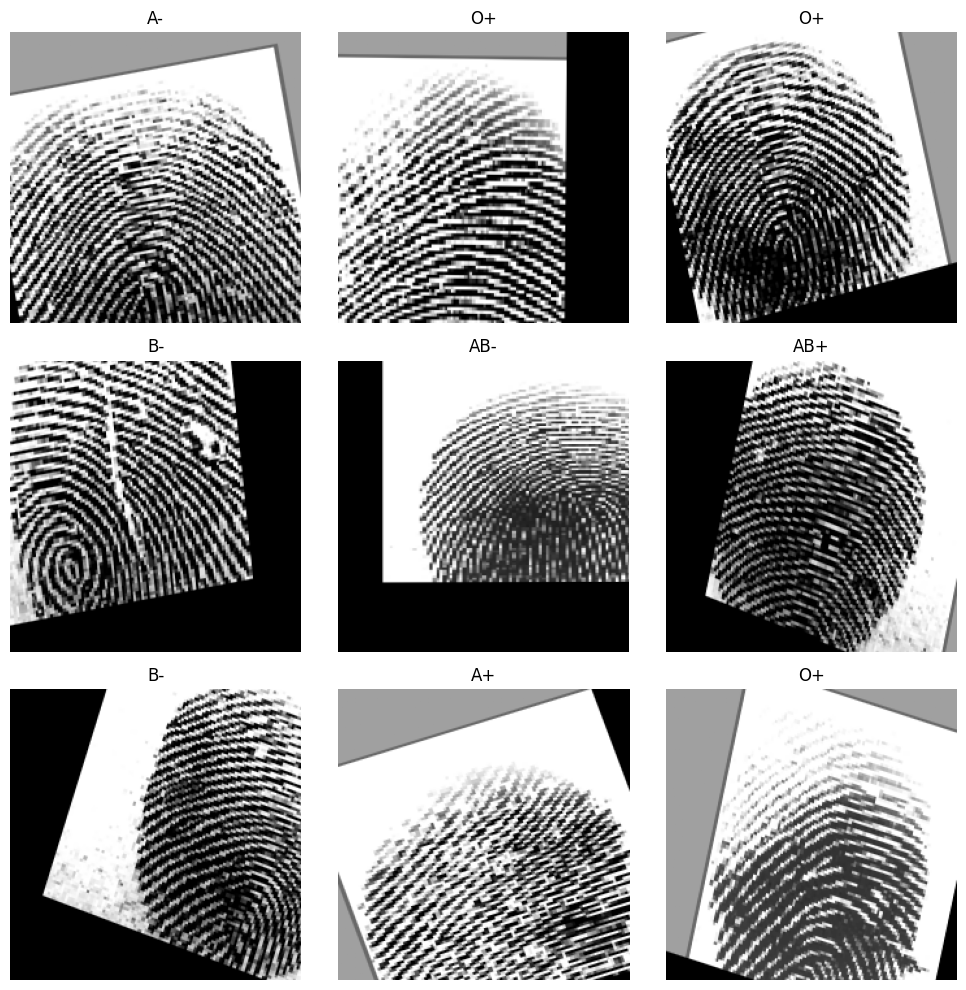

In [42]:
# Display sample images
def show_batch(image_batch, label_batch, class_indices):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        
        # Convert one-hot encoded label back to class name
        label_idx = np.argmax(label_batch[i])
        class_names = {v: k for k, v in class_indices.items()}
        title = class_names[label_idx]
        
        plt.title(title)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Get a batch of training images and labels
image_batch, label_batch = next(iter(train_generator))
show_batch(image_batch, label_batch, train_generator.class_indices)

In [43]:
# CNN Model Architecture
model = Sequential([
    # First Convolutional Layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Second Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Third Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Fourth Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the results to feed into dense layer
    Flatten(),
    
    # Dense hidden layer
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout to prevent overfitting
    
    # Output layer
    Dense(len(blood_groups), activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,682,632 (36.94 MB)

 Trainable params: 9,682,632 (36.94 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Callbacks
checkpoint = ModelCheckpoint(
    'blood_group_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

callbacks = [checkpoint, early_stopping]

In [46]:
print(train_generator.class_indices)
print(validation_generator.class_indices)

{'A+': 0, 'A-': 1, 'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7}
{'A+': 0, 'A-': 1, 'AB+': 2, 'AB-': 3, 'B+': 4, 'B-': 5, 'O+': 6, 'O-': 7}


In [57]:
# Train the model
epochs = 30

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=callbacks
)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.4720 - loss: 1.3740
Epoch 1: val_accuracy improved from 0.44426 to 0.56503, saving model to blood_group_model_best.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 118s 783ms/step - accuracy: 0.4722 - loss: 1.3737 - val_accuracy: 0.5650 - val_loss: 1.1748
Epoch 2/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:44 699ms/step - accuracy: 0.6250 - loss: 1.1956
Epoch 2: val_accuracy did not improve from 0.56503
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.6250 - loss: 1.1956 - val_accuracy: 0.5557 - val_loss: 1.1451
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.5485 - loss: 1.2156
Epoch 3: val_accuracy improved from 0.56503 to 0.60642, saving model to blood_group_model_best.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 117s 782ms/step - accuracy: 0.5485 - loss: 1.2155 - val_accuracy: 0.6064 - val_loss: 1.0742
Epoch 4/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:42 690ms/step - accuracy: 0.6250 - loss: 0.9690
Epoch 4: val_accuracy did not improve from 0.60642
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.6250 - loss: 0.9690 - val_accuracy: 0.5904 - val_loss: 1.1125
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.5689 - loss: 1.1430
Epoch 5: val_accuracy did not improve from 0.60642
150/150 ━━━━━━━━━━━━━━━━━━━━ 111s 739ms/step - accuracy: 0.5689 - loss: 1.1429 - val_accuracy: 0.6047 - val_loss: 1.0217
Epoch 6/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:23 562ms/step - accuracy: 0.5000 - loss: 1.1534
Epoch 6: val_accuracy did not improve from 0.60642
150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.5000 - loss: 1.1534 - val_accuracy: 0.6039 - val_loss: 1.0348
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.5800 - loss: 1.1052
Epoch 7: va

150/150 ━━━━━━━━━━━━━━━━━━━━ 107s 711ms/step - accuracy: 0.5801 - loss: 1.1050 - val_accuracy: 0.6149 - val_loss: 0.9773
Epoch 8/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:26 582ms/step - accuracy: 0.7500 - loss: 0.9259
Epoch 8: val_accuracy improved from 0.61486 to 0.62669, saving model to blood_group_model_best.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.7500 - loss: 0.9259 - val_accuracy: 0.6267 - val_loss: 0.9921
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.6282 - loss: 1.0062
Epoch 9: val_accuracy improved from 0.62669 to 0.63091, saving model to blood_group_model_best.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 106s 708ms/step - accuracy: 0.6282 - loss: 1.0063 - val_accuracy: 0.6309 - val_loss: 0.9894
Epoch 10/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:32 620ms/step - accuracy: 0.3750 - loss: 1.2514
Epoch 10: val_accuracy improved from 0.63091 to 0.65034, saving model to blood_group_model_best.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.3750 - loss: 1.2514 - val_accuracy: 0.6503 - val_loss: 0.9657
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.6425 - loss: 0.9745
Epoch 11: val_accuracy improved from 0.65034 to 0.67736, saving model to blood_group_model_best.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 106s 706ms/step - accuracy: 0.6424 - loss: 0.9746 - val_accuracy: 0.6774 - val_loss: 0.8646
Epoch 12/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:21 547ms/step - accuracy: 0.6875 - loss: 0.9760
Epoch 12: val_accuracy improved from 0.67736 to 0.69510, saving model to blood_group_model_best.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.6875 - loss: 0.9760 - val_accuracy: 0.6951 - val_loss: 0.8867
Epoch 13/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.6398 - loss: 0.9583
Epoch 13: val_accuracy did not improve from 0.69510
150/150 ━━━━━━━━━━━━━━━━━━━━ 114s 757ms/step - accuracy: 0.6398 - loss: 0.9582 - val_accuracy: 0.6824 - val_loss: 0.8285
Epoch 14/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:35 643ms/step - accuracy: 0.7188 - loss: 0.9228
Epoch 14: val_accuracy did not improve from 0.69510
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.7188 - loss: 0.9228 - val_accuracy: 0.6596 - val_loss: 0.8790
Epoch 15/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.6577 - loss: 0.9180
Epoch 15: val_accuracy improved from 0.69510 to 0.71115, saving model to blood_group_model_best.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 116s 771ms/step - accuracy: 0.6577 - loss: 0.9180 - val_accuracy: 0.7111 - val_loss: 0.7795
Epoch 16/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:39 667ms/step - accuracy: 0.6875 - loss: 1.0606
Epoch 16: val_accuracy did not improve from 0.71115
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.6875 - loss: 1.0606 - val_accuracy: 0.7044 - val_loss: 0.8323
Epoch 17/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 677ms/step - accuracy: 0.6711 - loss: 0.8874
Epoch 17: val_accuracy did not improve from 0.71115
150/150 ━━━━━━━━━━━━━━━━━━━━ 113s 753ms/step - accuracy: 0.6711 - loss: 0.8875 - val_accuracy: 0.7035 - val_loss: 0.7689
Epoch 18/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:28 595ms/step - accuracy: 0.7500 - loss: 0.6825
Epoch 18: val_accuracy did not improve from 0.71115
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.7500 - loss: 0.6825 - val_accuracy: 0.6926 - val_loss: 0.8280
Epoch 19/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.6662 - loss: 0.8999
Epoc

150/150 ━━━━━━━━━━━━━━━━━━━━ 113s 754ms/step - accuracy: 0.6887 - loss: 0.8390 - val_accuracy: 0.7188 - val_loss: 0.7439
Epoch 22/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:37 655ms/step - accuracy: 0.6562 - loss: 0.8112
Epoch 22: val_accuracy did not improve from 0.71875
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.6562 - loss: 0.8112 - val_accuracy: 0.7086 - val_loss: 0.7739
Epoch 23/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.6872 - loss: 0.8348
Epoch 23: val_accuracy did not improve from 0.71875
150/150 ━━━━━━━━━━━━━━━━━━━━ 114s 756ms/step - accuracy: 0.6872 - loss: 0.8348 - val_accuracy: 0.6706 - val_loss: 0.8374
Epoch 24/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:28 593ms/step - accuracy: 0.6875 - loss: 0.7627
Epoch 24: val_accuracy did not improve from 0.71875
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.6875 - loss: 0.7627 - val_accuracy: 0.7019 - val_loss: 0.7924
Epoch 25/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 684ms/step - accuracy: 0.6819 - loss: 0.8660
Epoc

150/150 ━━━━━━━━━━━━━━━━━━━━ 117s 781ms/step - accuracy: 0.6709 - loss: 0.8609 - val_accuracy: 0.7196 - val_loss: 0.7348
Epoch 28/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:37 656ms/step - accuracy: 0.6562 - loss: 1.1056
Epoch 28: val_accuracy did not improve from 0.71959
150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.6562 - loss: 1.1056 - val_accuracy: 0.6892 - val_loss: 0.7962
Epoch 29/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.7036 - loss: 0.8207
Epoch 29: val_accuracy improved from 0.71959 to 0.72382, saving model to blood_group_model_best.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 114s 762ms/step - accuracy: 0.7036 - loss: 0.8206 - val_accuracy: 0.7238 - val_loss: 0.7286
Epoch 30/30
  1/150 ━━━━━━━━━━━━━━━━━━━━ 1:39 670ms/step - accuracy: 0.7812 - loss: 0.6808
Epoch 30: val_accuracy improved from 0.72382 to 0.73226, saving model to blood_group_model_best.h5


150/150 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - accuracy: 0.7812 - loss: 0.6808 - val_accuracy: 0.7323 - val_loss: 0.7067


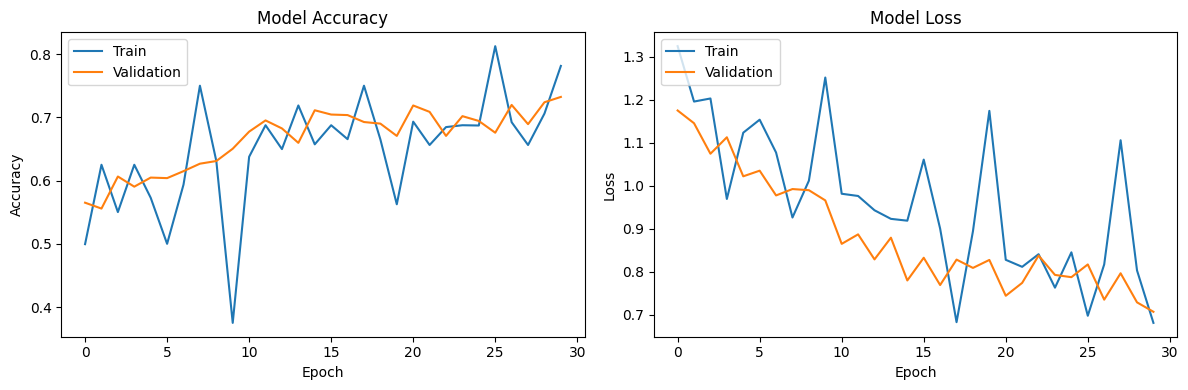

In [58]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [59]:
# Evaluate the model on validation set
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true classes
validation_generator.reset()
y_true = []
for i in range(len(validation_generator)):
    _, label_batch = next(validation_generator)
    y_true.extend(np.argmax(label_batch, axis=1))
y_true = y_true[:len(y_pred_classes)]  # Make sure lengths match

38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 324ms/step


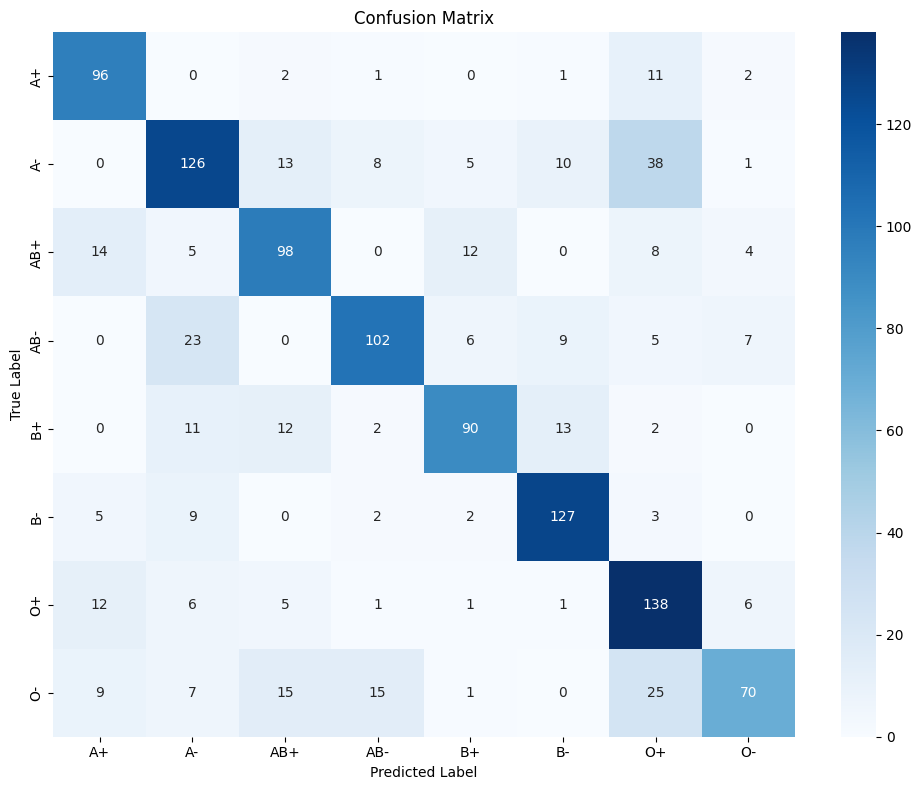

              precision    recall  f1-score   support

          A+       0.71      0.85      0.77       113
          A-       0.67      0.63      0.65       201
         AB+       0.68      0.70      0.69       141
         AB-       0.78      0.67      0.72       152
          B+       0.77      0.69      0.73       130
          B-       0.79      0.86      0.82       148
          O+       0.60      0.81      0.69       170
          O-       0.78      0.49      0.60       142

    accuracy                           0.71      1197
   macro avg       0.72      0.71      0.71      1197
weighted avg       0.72      0.71      0.70      1197



In [60]:
# Get class names
class_indices = validation_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_names.values()),
            yticklabels=list(class_names.values()))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Print classification report
print(classification_report(y_true, y_pred_classes, target_names=list(class_names.values())))

In [61]:
# Save the final model
model.save('blood_group_model_final.h5')
print("Model saved successfully!")

Model saved successfully!


In [62]:
# Function for making predictions on a new fingerprint image
def predict_blood_group(image_path):
    from tensorflow.keras.preprocessing import image
    
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Make prediction
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction[0])
    predicted_blood_group = class_names[predicted_class]
    confidence = prediction[0][predicted_class] * 100
    
    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_blood_group} (Confidence: {confidence:.2f}%)")
    plt.axis('off')
    plt.show()
    
    # Print probabilities for all classes
    for i, prob in enumerate(prediction[0]):
        print(f"{class_names[i]}: {prob*100:.2f}%")
    
    return predicted_blood_group, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


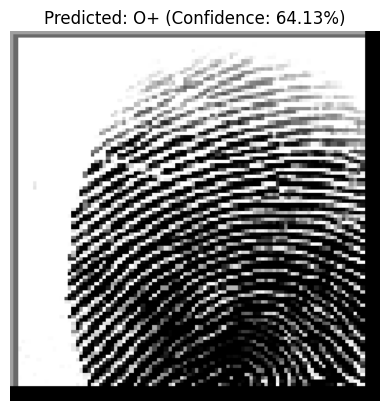

A+: 35.85%
A-: 0.00%
AB+: 0.01%
AB-: 0.00%
B+: 0.00%
B-: 0.00%
O+: 64.13%
O-: 0.01%


In [63]:
# Test prediction with a sample image from validation set
# You can replace this with your own test image path
sample_blood_group = list(class_names.values())[0]
sample_dir = os.path.join(dataset_path, sample_blood_group)
sample_images = os.listdir(sample_dir)

if sample_images:
    sample_image_path = os.path.join(sample_dir, sample_images[0])
    predict_blood_group(sample_image_path)